# Fingerprint distances between structures for the same kinase

We investigate the ranges of fingerprint distances for each kinase pair:

- Compare the fingerprint distance distribution for intra-kinase pairs and inter-kinase pairs
- For the kinase pairs with highest structure pair coverage, show the range of fingerprint distances (consider minimum or median for structure-to-kinase mapping)
- Generate `kissim` kinase matrix for kinase subset investigated in the paper ["Analyzing Kinase Similarity in Small Molecule and Protein Structural Space to Explore the Limits of Multi-Target Screening"](https://www.mdpi.com/1420-3049/26/3/629)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from opencadd.databases.klifs import setup_remote

from kissim.comparison import FingerprintDistanceGenerator

In [3]:
HERE = Path(_dh[-1])  # noqa: F821
DATA = HERE / "../../results/"

In [4]:
plt.style.use("seaborn")

In [5]:
%matplotlib inline

In [6]:
COVERAGE_CUTOFF = 0.8

## Load structural metadata

In [7]:
klifs_session = setup_remote()
structures = klifs_session.structures.all_structures()

## Load fingerprint distances

In [8]:
fingerprint_distance_file = DATA / "fingerprint_distances.csv"

In [9]:
fingerprint_distance_generator = FingerprintDistanceGenerator.from_csv(fingerprint_distance_file)

In [10]:
print(f"Number of kinases: {len(fingerprint_distance_generator.kinase_ids)}")
print(f"Number of structures: {len(fingerprint_distance_generator.structure_ids)}")

Number of kinases: 292
Number of structures: 5222


In [11]:
structure_distances = fingerprint_distance_generator.data
structure_distances.head()

,structure.1,structure.2,kinase.1,kinase.2,distance,bit_coverage
0,3833,6679,AAK1,AAK1,0.051595,0.992667
1,3833,7156,AAK1,AAK1,0.057489,0.991333
2,3833,1086,AAK1,ABL1,0.271736,0.990667
3,3833,1054,AAK1,ABL1,0.290077,0.990667
4,3833,1090,AAK1,ABL1,0.266234,0.990667


### Add DFG conformation

In [12]:
%%time
dfg = structures.set_index("structure.klifs_id")["structure.dfg"]
structure_distances["dfg.1"] = structure_distances["structure.1"].apply(lambda x: dfg[x])
structure_distances["dfg.2"] = structure_distances["structure.2"].apply(lambda x: dfg[x])

CPU times: user 1min 21s, sys: 459 ms, total: 1min 22s
Wall time: 1min 22s


### Filter distances by coverage cutoff

In [13]:
structure_distances["distance_filtered"] = np.where(
    structure_distances["bit_coverage"].values < COVERAGE_CUTOFF,
    np.nan,
    structure_distances["distance"].values,
)
structure_distances.head()

,structure.1,structure.2,kinase.1,kinase.2,distance,bit_coverage,dfg.1,dfg.2,distance_filtered
0,3833,6679,AAK1,AAK1,0.051595,0.992667,in,in,0.051595
1,3833,7156,AAK1,AAK1,0.057489,0.991333,in,in,0.057489
2,3833,1086,AAK1,ABL1,0.271736,0.990667,in,out-like,0.271736
3,3833,1054,AAK1,ABL1,0.290077,0.990667,in,out,0.290077
4,3833,1090,AAK1,ABL1,0.266234,0.990667,in,in,0.266234


In [14]:
structure_distances_filtered = structure_distances[
    structure_distances["distance_filtered"].notna()
]

In [15]:
print(f"Structure pairs: {structure_distances.shape[0]}")
print(f"Structure pairs not-NaN: {structure_distances_filtered.shape[0]}")

Structure pairs: 13632031
Structure pairs not-NaN: 13486109


## Structure distances

### Structure distance distributions for different subsets

- All structure distances
- Structure distances between the same kinases
- Structure distances between different kinases

#### Without coverage cutoff

In [16]:
structure_distances_df = pd.DataFrame(
    {
        "all": structure_distances["distance"],
        "intra-kinase": structure_distances[
            structure_distances["kinase.1"] == structure_distances["kinase.2"]
        ]["distance"],
        "inter-kinase": structure_distances[
            ~(structure_distances["kinase.1"] == structure_distances["kinase.2"])
        ]["distance"],
    }
)

In [17]:
structure_distances_df.notna().sum()

all             13632031
intra-kinase      265717
inter-kinase    13366314
dtype: int64

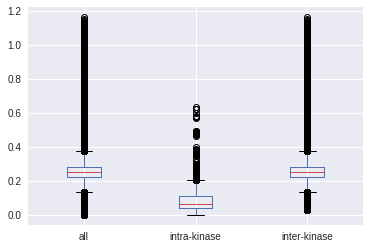

In [18]:
structure_distances_df.plot(kind="box");

In [19]:
structure_distances_df.describe()

,all,intra-kinase,inter-kinase
count,1.363203e+07,265717.000000,1.336631e+07
mean,2.594330e-01,0.076412,2.630713e-01
std,6.651216e-02,0.042813,6.161360e-02
min,0.000000e+00,0.000000,2.646436e-02
25%,2.237365e-01,0.043465,2.255455e-01
50%,2.507428e-01,0.062216,2.517623e-01
75%,2.837944e-01,0.109169,2.847320e-01
max,1.164113e+00,0.632649,1.164113e+00


#### With coverage cutoff

In [20]:
structure_distances_filtered_df = pd.DataFrame(
    {
        "all": structure_distances_filtered["distance"],
        "intra-kinase": structure_distances_filtered[
            structure_distances_filtered["kinase.1"] == structure_distances_filtered["kinase.2"]
        ]["distance"],
        "inter-kinase": structure_distances_filtered[
            ~(structure_distances_filtered["kinase.1"] == structure_distances_filtered["kinase.2"])
        ]["distance"],
    }
)

In [21]:
structure_distances_filtered_df.notna().sum()

all             13486109
intra-kinase      264656
inter-kinase    13221453
dtype: int64

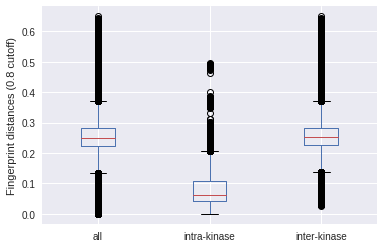

In [22]:
fig, axes = plt.subplots(1, 1)
structure_distances_filtered_df.plot(kind="box", ax=axes)
axes.set_ylabel(f"Fingerprint distances ({COVERAGE_CUTOFF} cutoff)");

In [23]:
structure_distances_filtered_df.describe()

,all,intra-kinase,inter-kinase
count,1.348611e+07,264656.000000,1.322145e+07
mean,2.581390e-01,0.076174,2.617814e-01
std,6.362613e-02,0.042594,5.845462e-02
min,0.000000e+00,0.000000,2.646436e-02
25%,2.234458e-01,0.043406,2.252617e-01
50%,2.503013e-01,0.062025,2.513161e-01
75%,2.827976e-01,0.108673,2.837103e-01
max,6.492761e-01,0.494849,6.492761e-01


### Per kinase distributions

How robust are structure distances within kinase pairs?

#### All kinase pairs

In [24]:
data = structure_distances_filtered[["kinase.1", "kinase.2", "distance"]].groupby(
    ["kinase.1", "kinase.2"]
)

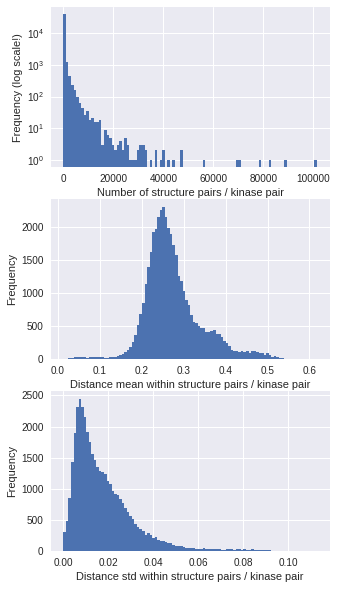

In [25]:
fig, axes = plt.subplots(3, 1, figsize=(5, 10))
# Size
data.size().plot(ax=axes[0], kind="hist", logy=True, style=".", bins=100)
axes[0].set_xlabel("Number of structure pairs / kinase pair")
axes[0].set_ylabel("Frequency (log scale!)")
# Mean
data.mean().squeeze().plot(ax=axes[1], kind="hist", style=".", bins=100)
axes[1].set_xlabel("Distance mean within structure pairs / kinase pair")
# Std
data.std().squeeze().plot(ax=axes[2], kind="hist", logy=False, style=".", bins=100)
axes[2].set_xlabel("Distance std within structure pairs / kinase pair");

In [26]:
print("size == 1: ", data.size()[data.size() == 1].shape[0])
print("size < 5: ", data.size()[data.size() < 5].shape[0])
print("size < 10: ", data.size()[data.size() < 10].shape[0])
print("size < 100: ", data.size()[data.size() < 100].shape[0])
print("size < 1000: ", data.size()[data.size() < 1000].shape[0])
print("size < 10000: ", data.size()[data.size() < 10000].shape[0])
print("size: ", data.size().shape[0])

size == 1:  1692
size < 5:  7060
size < 10:  11667
size < 100:  29063
size < 1000:  39005
size < 10000:  41338
size:  41512


In [27]:
data.mean().describe()

,distance
count,41512.000000
mean,0.274695
std,0.067388
min,0.013405
25%,0.232958
50%,0.261746
75%,0.302592
max,0.618020


In [28]:
data.std().describe()

,distance
count,39820.000000
mean,0.017530
std,0.013421
min,0.000002
25%,0.008009
50%,0.013918
75%,0.023404
max,0.112884


#### Most frequent kinase pairs (all conformations)

In [29]:
data = structure_distances_filtered.groupby(["kinase.1", "kinase.2"])

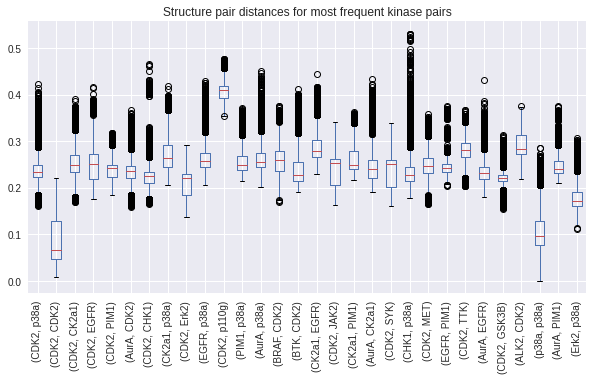

In [30]:
ntop = 30
index = data.size().sort_values(ascending=False).head(ntop).index
top_pair_distances = {pair: data.get_group(pair)["distance"] for pair in index}
top_pair_distances = pd.DataFrame(top_pair_distances)
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
top_pair_distances.plot(kind="box", ax=axes, rot=90)
axes.set_title("Structure pair distances for most frequent kinase pairs");

In [31]:
data_min = data.min()

In [32]:
print("Minimum pair has same conformations")
print(data_min[data_min["dfg.1"] == data_min["dfg.2"]].shape[0] / data_min.shape[0] * 100)

Minimum pair has same conformations
85.59693582578531


In [33]:
print("Minimum pair has different conformations")
print(data_min[data_min["dfg.1"] != data_min["dfg.2"]].shape[0] / data_min.shape[0] * 100)

Minimum pair has different conformations
14.403064174214686


#### Most frequent kinase pairs (DFG-in conformations only)

In [34]:
structure_distances_filtered_dfgin = structure_distances_filtered[
    (structure_distances_filtered["dfg.1"] == "in")
    & (structure_distances_filtered["dfg.2"] == "in")
]
structure_distances_filtered.shape, structure_distances_filtered_dfgin.shape

((13486109, 9), (10075272, 9))

In [35]:
data = structure_distances_filtered_dfgin.groupby(["kinase.1", "kinase.2"])

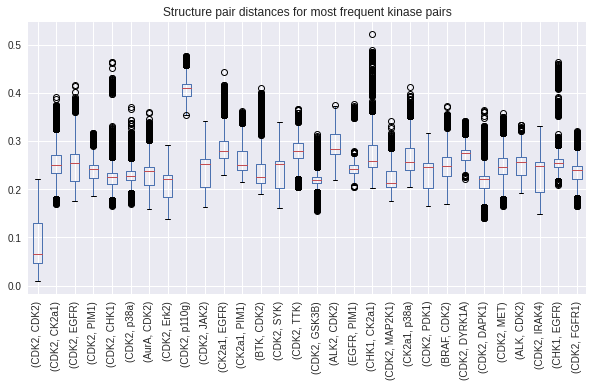

In [36]:
ntop = 30
index = data.size().sort_values(ascending=False).head(ntop).index
top_pair_distances = {pair: data.get_group(pair)["distance"] for pair in index}
top_pair_distances = pd.DataFrame(top_pair_distances)
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
top_pair_distances.plot(kind="box", ax=axes, rot=90)
axes.set_title("Structure pair distances for most frequent kinase pairs");

## Structure > kinase distances (median)

In [37]:
kinase_distances = structure_distances.groupby(["kinase.1", "kinase.2"]).median().reset_index()
kinase_distances.head()

,kinase.1,kinase.2,structure.1,structure.2,distance,bit_coverage,distance_filtered
0,AAK1,AAK1,3833.0,7156.0,0.051595,0.992667,0.051595
1,AAK1,ABL1,6679.0,1089.0,0.271495,0.990667,0.271495
2,AAK1,ABL2,6679.0,115.0,0.273894,0.990000,0.273894
3,AAK1,ACK,6679.0,3405.0,0.260771,0.990000,0.260771
4,AAK1,ACTR2,6679.0,2683.0,0.267072,0.990667,0.267072


In [38]:
kinase_distances_filtered = kinase_distances[kinase_distances["distance_filtered"].notna()]

In [39]:
print(f"Kinase pairs: {kinase_distances.shape[0]}")
print(f"Kinase pairs not-NaN: {kinase_distances_filtered.shape[0]}")

Kinase pairs: 42719
Kinase pairs not-NaN: 41512


## Kinase matrix

### All distances

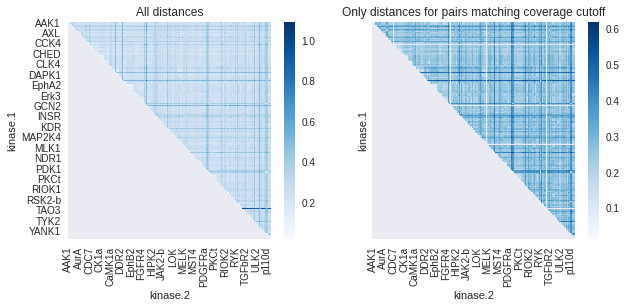

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
kinase_matrix = kinase_distances.pivot("kinase.1", "kinase.2", "distance")
sns.heatmap(kinase_matrix, cmap="Blues", ax=axes[0])
axes[0].set_title("All distances")
kinase_matrix = kinase_distances.pivot("kinase.1", "kinase.2", "distance_filtered")
sns.heatmap(kinase_matrix, cmap="Blues", ax=axes[1])
axes[1].set_title("Only distances for pairs matching coverage cutoff");

In [41]:
def n_pairs(n):
    return int((n ** 2 - n) / 2 + n)

In [42]:
n_structures = (
    pd.concat([structure_distances["structure.1"], structure_distances["structure.2"]])
    .unique()
    .shape[0]
)
n_kinases = (
    pd.concat([structure_distances["kinase.1"], structure_distances["kinase.2"]]).unique().shape[0]
)
n_structures_filtered = (
    pd.concat(
        [structure_distances_filtered["structure.1"], structure_distances_filtered["structure.2"]]
    )
    .unique()
    .shape[0]
)
n_kinases_filtered = (
    pd.concat([structure_distances_filtered["kinase.1"], structure_distances_filtered["kinase.2"]])
    .unique()
    .shape[0]
)


table = {
    "All distances": [
        n_structures,
        n_pairs(n_structures),
        structure_distances.shape[0],
        n_kinases,
        n_pairs(n_kinases),
        kinase_distances.shape[0],
    ],
    "Only distances matching cutoff": [
        n_structures_filtered,
        n_pairs(n_structures_filtered),
        structure_distances_filtered.shape[0],
        n_kinases_filtered,
        n_pairs(n_kinases_filtered),
        kinase_distances_filtered.shape[0],
    ],
}
table = pd.DataFrame(
    table,
    index=[
        "Number of structures",
        "Number of structure pairs (theory)",
        "Number of structure pairs (experimental)",
        "Number of kinases",
        "Number of kinase pairs (theory)",
        "Number of kinase pairs (experimental)",
    ],
)
table

,All distances,Only distances matching cutoff
Number of structures,5222,5199
Number of structure pairs (theory),13637253,13517400
Number of structure pairs (experimental),13632031,13486109
Number of kinases,292,288
Number of kinase pairs (theory),42778,41616
Number of kinase pairs (experimental),42719,41512


## Dual kinases paper dataset

https://www.mdpi.com/1420-3049/26/3/629

In [43]:
from itertools import combinations_with_replacement

In [44]:
KINASES_KLIFS_TO_PAPER = {
    "EGFR": "EGFR",
    "ErbB2": "ErbB2",
    "KDR": "VEGFR2",
    "p110a": "PI3K",
    "BRAF": "BRAF",
    "CDK2": "CDK2",
    "LCK": "LCK",
    "MET": "MET",
    "p38a": "p38a",
}

In [45]:
example_kinases = list(KINASES_KLIFS_TO_PAPER.keys())
print(example_kinases)
example_kinase_pairs = [i for i in combinations_with_replacement(example_kinases, 2)]

['EGFR', 'ErbB2', 'KDR', 'p110a', 'BRAF', 'CDK2', 'LCK', 'MET', 'p38a']


In [46]:
example_kinase_distances = kinase_distances_filtered[
    kinase_distances_filtered.apply(
        lambda x: (x["kinase.1"], x["kinase.2"]) in example_kinase_pairs, axis=1
    )
]

In [47]:
example_kinase_distances.shape

(35, 7)

In [48]:
example_kinase_matrix = example_kinase_distances.pivot("kinase.1", "kinase.2", "distance")
example_kinase_matrix = example_kinase_matrix.loc[example_kinases, example_kinases]
example_kinase_matrix

kinase.2,EGFR,ErbB2,KDR,p110a,BRAF,CDK2,LCK,MET,p38a
kinase.1,,,,,,,,,
EGFR,0.084314,0.154286,0.195551,0.384942,NaN,NaN,0.197355,0.232500,0.256960
ErbB2,NaN,0.148147,0.242609,0.383108,NaN,NaN,0.262605,0.244700,0.287057
KDR,NaN,NaN,0.060697,0.391770,NaN,NaN,0.201273,0.206311,0.238450
p110a,NaN,NaN,NaN,0.052957,NaN,NaN,NaN,NaN,0.390783
BRAF,NaN,NaN,NaN,NaN,0.10747,0.260314,0.246478,0.261213,0.275147
CDK2,NaN,NaN,NaN,NaN,NaN,0.067432,0.247347,0.246749,0.233417
LCK,NaN,NaN,NaN,NaN,NaN,NaN,0.038409,0.238004,0.248478
MET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.096729,0.278659
p38a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.095881


In [49]:
example_kinase_matrix.columns = [KINASES_KLIFS_TO_PAPER[i] for i in example_kinase_matrix.columns]
example_kinase_matrix.index = [KINASES_KLIFS_TO_PAPER[i] for i in example_kinase_matrix.index]
example_kinase_matrix

,EGFR,ErbB2,VEGFR2,PI3K,BRAF,CDK2,LCK,MET,p38a
EGFR,0.084314,0.154286,0.195551,0.384942,NaN,NaN,0.197355,0.232500,0.256960
ErbB2,NaN,0.148147,0.242609,0.383108,NaN,NaN,0.262605,0.244700,0.287057
VEGFR2,NaN,NaN,0.060697,0.391770,NaN,NaN,0.201273,0.206311,0.238450
PI3K,NaN,NaN,NaN,0.052957,NaN,NaN,NaN,NaN,0.390783
BRAF,NaN,NaN,NaN,NaN,0.10747,0.260314,0.246478,0.261213,0.275147
CDK2,NaN,NaN,NaN,NaN,NaN,0.067432,0.247347,0.246749,0.233417
LCK,NaN,NaN,NaN,NaN,NaN,NaN,0.038409,0.238004,0.248478
MET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.096729,0.278659
p38a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.095881


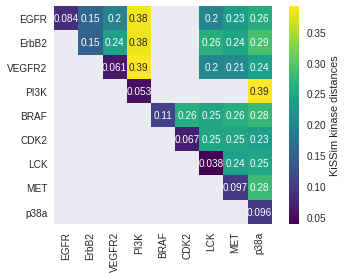

In [50]:
sns.heatmap(
    example_kinase_matrix,
    linewidths=0,
    annot=True,
    square=True,
    cbar_kws={"label": "KiSSim kinase distances"},
    cmap="viridis",
)
plt.show()

Compare to paper (shows similarities; not distances; __so think values inverse__):

![](https://www.mdpi.com/molecules/molecules-26-00629/article_deploy/html/images/molecules-26-00629-g002.png)

Figure 2. Heat maps of pairwise kinase similarities for the different measures used in this work: (A) ligand profile similarity (LigProfSim); (B) pocket sequence similarity (PocSeqSim); (C) interaction fingerprint similarity (IFPSim); (D) pocket structure similarity (PocStrucSim); and (E) docking rank similarity (DockRankSim) based on the lead-like subset of ZINC. Note that docking was only performed for the five kinases of Profiles 1–4, thus the remaining entries remain empty (white) in the matrix.